In [0]:
!nvidia-smi

Sat Aug 24 20:02:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   32C    P8    12W / 180W |      1MiB /  4043MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   48C    P8     8W / 200W |      2MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [0]:
import matplotlib.pyplot as plt
from mxnet import autograd, gluon, nd, init, context
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from IPython import display
import numpy as np

In [0]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : Animator.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
      """A utility function to set matplotlib axes"""
      axes.set_xlabel(xlabel)
      axes.set_ylabel(ylabel)
      axes.set_xscale(xscale)
      axes.set_yscale(yscale)
      axes.set_xlim(xlim)
      axes.set_ylim(ylim)
      if legend: axes.legend(legend)
      axes.grid()
    
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [0]:
def get_dataloader(batch_size, resize=None, shuffle=True):
  transform_list = []
  if(resize != None):
    transform_list.append(transforms.Resize(resize))
  transform_list.append(transforms.ToTensor())
  transformer = transforms.Compose(transform_list)
  
  train = gluon.data.vision.datasets.FashionMNIST(train=True)
  train = train.transform_first(transformer)
  train_iter = gluon.data.DataLoader(train, batch_size, shuffle=shuffle, num_workers=4)
  test = gluon.data.vision.datasets.FashionMNIST(train=False)
  test = test.transform_first(transformer)
  test_iter = gluon.data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
  return train_iter, test_iter, train, test

In [0]:
def show_images(X, nrows, ncols):
  _, axes = plt.subplots(nrows, ncols)
  axes = axes.flatten()
  
  for img, ax in zip(X, axes):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  return axes

In [0]:
def eval_loss(net, data_iter, loss, ctx, one_batch=False):
  l = 0
  size = 0
  for X, y in data_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    l += loss(net(X), y).sum().asscalar()
    size += len(y)
    if one_batch:
        break
  return l / size

In [0]:
def eval_acc(net, data_iter, ctx, one_batch=False):
  acc = 0
  size = 0
  for X, y in data_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    result = net(X).softmax(axis=1).argmax(axis=1)
    acc += (result == y.astype('float32')).sum().asscalar()
    size += len(y)
    if one_batch:
        break
  return acc / size

In [0]:
def evaluate(net, data_iter, loss, ctx, one_batch=False):
    acc = 0
    l = 0
    size = 0
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        result = net(X)
        l += loss(result, y).sum().asscalar()
        acc += (result.softmax(axis=1).argmax(axis=1) == y.astype('float32')).sum().asscalar()
        size += len(y)
    return l/size, acc /size

In [0]:
class NiN(nn.Block):
  def __init__(self, config, num_classes, **kwargs):
    super(NiN, self).__init__(**kwargs)
    self.config = config
    self.network = self.get_network(config, num_classes)
  
  def forward(self, x):
    x = self.network(x)
    return x
  
  def __getitem__(self, key):
    return self.network[key]
  
  def __len__(self):
    return len(self.config)+3

  def nin_block(self, num_channels, kernel_size, strides, padding):
    blk = nn.Sequential()
    blk.add(nn.Conv2D(num_channels, kernel_size, strides, padding, activation='relu'))
    blk.add(nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    blk.add(nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return blk
  
  def get_network(self, config, num_classes):
    blk = nn.Sequential()
    for vals in config:
      if vals[0] == 'pool':
        blk.add(nn.MaxPool2D(*vals[1:]))
      else:
        blk.add(self.nin_block(*vals[1:]))
    blk.add(nn.GlobalAvgPool2D())
    blk.add(nn.Flatten())
    return blk
    

In [0]:
batch_size = 16
resize = 224
config = [('mlpconv', 96, 11, 4, 0), ('pool', 3, 2), ('mlpconv', 256, 5, 1, 2), ('pool', 3, 2), ('mlpconv', 384, 3, 1, 1), ('pool', 3, 2), ('mlpconv', 10, 3, 1, 1)]
num_classes = 10

train_iter, test_iter, train, test = get_dataloader(batch_size, resize, shuffle=True)

(16, 1, 224, 224)
(16,)


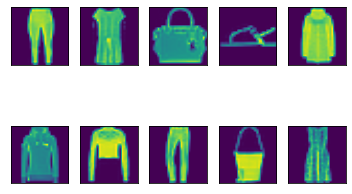

In [0]:
for X, y in train_iter:
  print(X.shape)
  print(y.shape)
  show_images(X.squeeze(axis=1).asnumpy(), 2, 5)
  break

In [0]:
ctx = context.gpu(1)

net = NiN(config, num_classes)
net.initialize(init=init.Xavier(), ctx=ctx)

testX = nd.random.normal(shape=(1, 1, 224, 224), ctx=ctx)

for layer in net:
  testX = layer(testX)
  print(layer.name, testX.shape)

print(testX)

sequential1 (1, 96, 54, 54)
pool0 (1, 96, 26, 26)
sequential2 (1, 256, 26, 26)
pool1 (1, 256, 12, 12)
sequential3 (1, 384, 12, 12)
pool2 (1, 384, 5, 5)
sequential4 (1, 10, 5, 5)
pool3 (1, 10, 1, 1)
flatten0 (1, 10)

[[3.05821050e-05 2.17984998e-05 3.21022538e-03 2.71621364e-04
  6.54711854e-04 2.85987917e-04 3.68742418e-04 1.04931845e-04
  2.04029027e-04 2.18267925e-03]]
<NDArray 1x10 @gpu(1)>


In [0]:
print(net.collect_params())

nin0_ (
  Parameter conv0_weight (shape=(96, 1, 11, 11), dtype=<class 'numpy.float32'>)
  Parameter conv0_bias (shape=(96,), dtype=<class 'numpy.float32'>)
  Parameter conv1_weight (shape=(96, 96, 1, 1), dtype=<class 'numpy.float32'>)
  Parameter conv1_bias (shape=(96,), dtype=<class 'numpy.float32'>)
  Parameter conv2_weight (shape=(96, 96, 1, 1), dtype=<class 'numpy.float32'>)
  Parameter conv2_bias (shape=(96,), dtype=<class 'numpy.float32'>)
  Parameter conv3_weight (shape=(256, 96, 5, 5), dtype=<class 'numpy.float32'>)
  Parameter conv3_bias (shape=(256,), dtype=<class 'numpy.float32'>)
  Parameter conv4_weight (shape=(256, 256, 1, 1), dtype=<class 'numpy.float32'>)
  Parameter conv4_bias (shape=(256,), dtype=<class 'numpy.float32'>)
  Parameter conv5_weight (shape=(256, 256, 1, 1), dtype=<class 'numpy.float32'>)
  Parameter conv5_bias (shape=(256,), dtype=<class 'numpy.float32'>)
  Parameter conv6_weight (shape=(384, 256, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter conv6_bi

In [0]:
acc = eval_acc(net, train_iter, ctx)
print(acc)

In [0]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()
l = 0
for X, y in train_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    l += loss(net(X), y).sum()
    break
print(l)
zeros = nd.zeros(shape=(1, 1, 224, 224)).as_in_context(ctx)
print(net(zeros))


[36.839996]
<NDArray 1 @gpu(1)>

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 1x10 @gpu(1)>


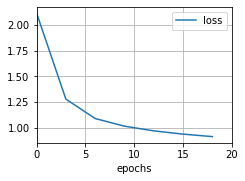

In [0]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':3e-6})
epochs = 20
animator = Animator(xlabel='epochs', xlim=[0, epochs], legend=['loss'])

for epoch in range(epochs):
  lval = 0
  size = 0
  for X, y in train_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    with autograd.record(): 
      l = loss(net(X), y)
    l.backward()
    lval += l.sum().asscalar()
    size += X.shape[0]
    trainer.step(batch_size)
  if epoch % 3 == 0:
    animator.add(epoch, lval/size)

In [0]:
final_acc = eval_acc(net, test_iter, ctx)
print('Class acc: %f' % (final_acc))

Class acc: 0.660900


In [0]:
nn.Conv2D?